In [ ]:
!nvidia-smi

Tue Jan 26 14:39:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:62:00.0 Off |                    0 |
| N/A   48C    P0    64W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                    0 |
| N/A   

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
imdb_df = pd.read_csv('IMDB_Dataset.csv', index_col = None)

In [ ]:
imdb_df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [ ]:
label = []

for index, row in imdb_df.iterrows():
    if(row['sentiment'] == 'positive'): label.append(1)
    else: label.append(0)

In [ ]:
imdb_df['label'] = label

imdb_df = imdb_df.drop(['sentiment'], axis = 1)

In [ ]:
imdb_df = imdb_df.head(10000)

In [ ]:
imdb_df.label.value_counts()

1    5028
0    4972
Name: label, dtype: int64

In [ ]:
PRETRAINED_MODEL_NAME = 'roberta-large'
PRETRAINED_MODEL_PATH = '../models/' + PRETRAINED_MODEL_NAME

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

In [ ]:
roberta_model = RobertaForSequenceClassification.from_pretrained(PRETRAINED_MODEL_PATH)
roberta_tok = RobertaTokenizer.from_pretrained(PRETRAINED_MODEL_PATH)

Some weights of the model checkpoint at ../models/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../models/roberta-large and are newly initialized: ['classifier.den

In [ ]:
import torch
from sklearn.model_selection import train_test_split

In [ ]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(review, 
                                             add_special_tokens = True,
                                             max_length = self.max_len, 
                                             truncation = True,
                                             return_tensors = 'pt',
                                             return_token_type_ids = False,
                                             return_attention_mask = True,
                                             padding = 'max_length')
        
        return{
            'review_text': review,
            'input_ids' : encoding['input_ids'].flatten(),
            'attention_mask' : encoding['attention_mask'].flatten(),
            'labels' : torch.tensor(label, dtype=torch.long)            
        }

In [ ]:
df_train, df_val = train_test_split(imdb_df, test_size = 0.3, random_state = 2021)
print(df_train.shape, df_val.shape)

(7000, 2) (3000, 2)


In [ ]:
print(df_train.label.value_counts())
print(df_val.label.value_counts())

1    3571
0    3429
Name: label, dtype: int64
0    1543
1    1457
Name: label, dtype: int64


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CreateDataset(reviews = df.review.to_numpy(),
                       labels = df.label.to_numpy(),
                       tokenizer = tokenizer,
                       max_len = max_len
                      )
    
    return torch.utils.data.DataLoader(ds, 
                                       batch_size = batch_size, 
                                       num_workers = 4)

In [ ]:
MAX_LEN = 512
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, roberta_tok, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, roberta_tok, MAX_LEN, BATCH_SIZE)

In [ ]:
check_data = next(iter(train_data_loader))
check_data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
# Uncomment and run this cell to visualize the roberta-large architecture
#roberta_model

In [ ]:
# Embedding layer
#roberta_model.roberta.embeddings

In [ ]:
# Encoder Layers
#roberta_model.roberta.encoder

In [ ]:
# Classifier Layer
#roberta_model.classifier

In [ ]:
class MultiGPUClassifier(torch.nn.Module):
    def __init__(self, roberta_model):
        super(MultiGPUClassifier, self).__init__()
        self.embedding = roberta_model.roberta.embeddings.to('cuda:0')
        self.encoder = roberta_model.roberta.encoder.to('cuda:1')
        self.classifier = roberta_model.classifier.to('cuda:1')
        
    def forward(self, input_ids, token_type_ids = None, attention_mask = None, labels = None):
        emb_out = self.embedding(input_ids.to('cuda:0'))
        enc_out = self.encoder(emb_out.to('cuda:1'))
        classifier_out = self.classifier(enc_out[0])
        return classifier_out        

In [ ]:
!nvidia-smi

Tue Jan 26 14:39:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:62:00.0 Off |                    0 |
| N/A   47C    P0    43W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                    0 |
| N/A   

In [ ]:
multi_gpu_roberta = MultiGPUClassifier(roberta_model)

In [ ]:
from transformers import get_linear_schedule_with_warmup, AdamW

In [ ]:
EPOCHS = 2
LR = 1e-5

optimizer = AdamW(multi_gpu_roberta.parameters(), lr = LR)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = 0, 
                                           num_training_steps = total_steps)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss().to('cuda:1')

In [ ]:
def train_model(model, data_loader, loss_fn, optimizer, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids']
        attention_mask = d['attention_mask']
        reshaped_attention_mask = attention_mask.reshape(d['attention_mask'].shape[0], 1, 1, d['attention_mask'].shape[1])
        targets = d['labels']
        
        outputs= model(input_ids = input_ids, attention_mask = reshaped_attention_mask)
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets.to('cuda:1'))
        
        correct_predictions += torch.sum(preds == targets.to('cuda:1'))
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)
        

In [ ]:
def eval_model(model, data_loader, loss_fn, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids']
            attention_mask = d['attention_mask']
            reshaped_attention_mask = attention_mask.reshape(d['attention_mask'].shape[0], 1, 1, d['attention_mask'].shape[1])
            targets = d['labels']
            
            outputs = model(input_ids = input_ids, attention_mask = reshaped_attention_mask)
            _, preds = torch.max(outputs, dim = 1)
            
            loss = loss_fn(outputs, targets.to('cuda:1'))
            
            correct_predictions += torch.sum(preds == targets.to('cuda:1'))
            losses.append(loss.item())
            
        return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

In [ ]:
%%time

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_model(multi_gpu_roberta, train_data_loader, loss_fn, optimizer, scheduler, len(df_train))
    print(f'Train Loss: {train_loss} ; Train Accuracy: {train_acc}')
    
    val_acc, val_loss = eval_model(multi_gpu_roberta, val_data_loader, loss_fn, len(df_val))
    print(f'Val Loss: {val_loss} ; Val Accuracy: {val_acc}')
    
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(multi_gpu_roberta.state_dict(), 'multi_gpu_roberta_best_model_state.bin')
        best_acc = val_acc

Epoch 1/2
----------
Train Loss: 0.3271573152278683 ; Train Accuracy: 0.8830000000000001
Val Loss: 0.19180121847156745 ; Val Accuracy: 0.9593333333333333

Epoch 2/2
----------
Train Loss: 0.14536982661844897 ; Train Accuracy: 0.9690000000000001
Val Loss: 0.2031460166494362 ; Val Accuracy: 0.9633333333333333

CPU times: user 21min 51s, sys: 8min 6s, total: 29min 57s
Wall time: 30min 8s


In [ ]:
import matplotlib.pyplot as plt

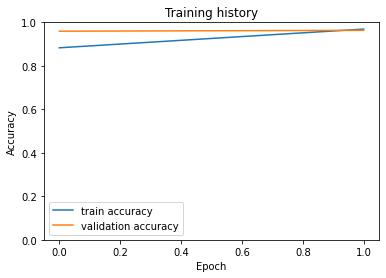

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"]
            attention_mask = d["attention_mask"]
            labels = d["labels"]

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(labels)
        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(multi_gpu_roberta, val_data_loader)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
class_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.96      0.96      0.96      1543
    positive       0.96      0.96      0.96      1457

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



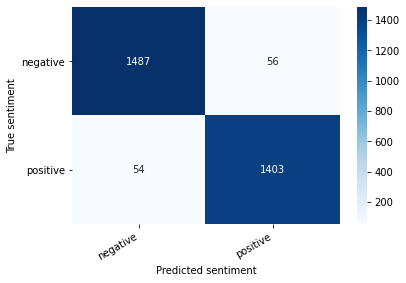

In [ ]:
def show_confusion_matrix(confusion_matrix):
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
    
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 1
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame({'class_names': class_names, 
                        'values': y_pred_probs[idx] 
                       })

print(review_text)
print()
print(f'True sentiment: {class_names[true_sentiment]}')

This movie starts by showing you a map and then explaining radar and it is quite awhile before you ever see the deadly mantis. Probably a better movie in the 50's this dated piece is a bit to slow moving and the pay off in the end isn't very good. Though it has its moments like when the guy from Perry Mason argues with an old man and when he says "I have narrowed the possibilities to one" excuse me, but when you narrow something down you have a couple or more possibilities not one...if you get it down to one you haven't narrowed it down, but you have in fact figured out what it is. The monster is standard 50's sci-fi fair, better than say the grasshoppers in the Beginning of the End. Acting is sub-par and the heroine is the most unattractive...in fact in some shots she does look like a guy in drag. You see plenty of fighter plane stock footage and other things, but you won't see much at all of the deadly mantis.

True sentiment: negative


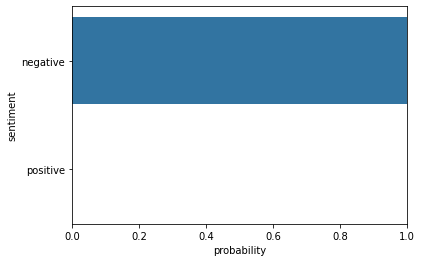

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);